In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

In [2]:
BASE = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"

def fetch_year(year, chunk_size=50000):
    print(f"\nFetching {year}...")
    
    where = f"""
    date >= '{year}-01-01T00:00:00.000'
    AND date < '{year+1}-01-01T00:00:00.000'
    AND latitude IS NOT NULL
    AND longitude IS NOT NULL
    """.replace("\n", " ").strip()
    
    select = """
    id, date, primary_type, arrest, domestic,
    community_area, district,
    latitude, longitude
    """.replace("\n", " ").strip()
    
    offset = 0
    frames = []
    
    while True:
        params = {
            "$select": select,
            "$where": where,
            "$limit": chunk_size,
            "$offset": offset,
            "$order": "date ASC"
        }
        
        r = requests.get(BASE, params=params, timeout=60)
        r.raise_for_status()
        data = r.json()
        
        if not data:
            break
        
        df_chunk = pd.DataFrame(data)
        frames.append(df_chunk)
        offset += len(data)
        
        print(f"{year}: {offset} rows fetched")
        
        if len(data) < chunk_size:
            break
    
    if frames:
        df_year = pd.concat(frames, ignore_index=True)
        return df_year
    else:
        return pd.DataFrame()

In [3]:
all_years = []

for year in range(2015, 2025):  # 到2024
    df_year = fetch_year(year)
    
    df_year["date"] = pd.to_datetime(df_year["date"], errors="coerce")
    df_year["latitude"] = pd.to_numeric(df_year["latitude"], errors="coerce")
    df_year["longitude"] = pd.to_numeric(df_year["longitude"], errors="coerce")
    
    df_year = df_year.dropna(subset=["date", "latitude", "longitude"])
    
    df_year.to_parquet(f"crime_{year}.parquet", index=False)
    
    print(f"{year} saved: {df_year.shape}")


Fetching 2015...
2015: 50000 rows fetched
2015: 100000 rows fetched
2015: 150000 rows fetched
2015: 200000 rows fetched
2015: 250000 rows fetched
2015: 257908 rows fetched
2015 saved: (257908, 9)

Fetching 2016...
2016: 50000 rows fetched
2016: 100000 rows fetched
2016: 150000 rows fetched
2016: 200000 rows fetched
2016: 250000 rows fetched
2016: 267224 rows fetched
2016 saved: (267224, 9)

Fetching 2017...
2017: 50000 rows fetched
2017: 100000 rows fetched
2017: 150000 rows fetched
2017: 200000 rows fetched
2017: 250000 rows fetched
2017: 264936 rows fetched
2017 saved: (264936, 9)

Fetching 2018...
2018: 50000 rows fetched
2018: 100000 rows fetched
2018: 150000 rows fetched
2018: 200000 rows fetched
2018: 250000 rows fetched
2018: 263523 rows fetched
2018 saved: (263523, 9)

Fetching 2019...
2019: 50000 rows fetched
2019: 100000 rows fetched
2019: 150000 rows fetched
2019: 200000 rows fetched
2019: 250000 rows fetched
2019: 259170 rows fetched
2019 saved: (259170, 9)

Fetching 2020.

In [4]:
dfs = []
for year in range(2015, 2025):
    df_y = pd.read_parquet(f"crime_{year}.parquet")
    dfs.append(df_y)

df = pd.concat(dfs, ignore_index=True)

df.shape

(2477278, 9)

In [5]:
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()
df["year"] = df["date"].dt.year
df["weekday"] = df["date"].dt.dayofweek
df["hour"] = df["date"].dt.hour

<Axes: title={'center': 'Yearly crime trend (2015–2024)'}, xlabel='year'>

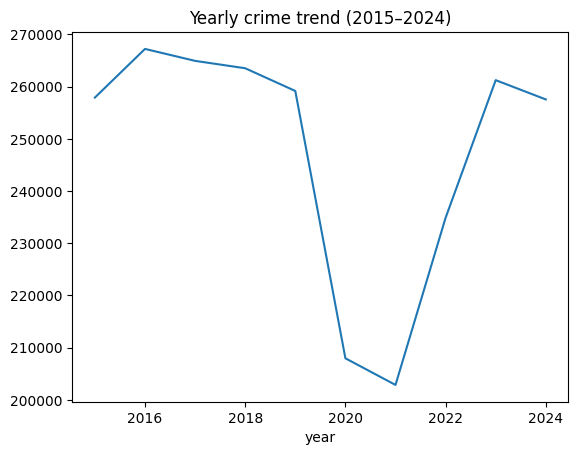

In [6]:
yearly = df.groupby("year").size()
yearly.plot(kind="line", title="Yearly crime trend (2015–2024)")

<Axes: title={'center': 'Monthly crime trend (2015–2024)'}, xlabel='month'>

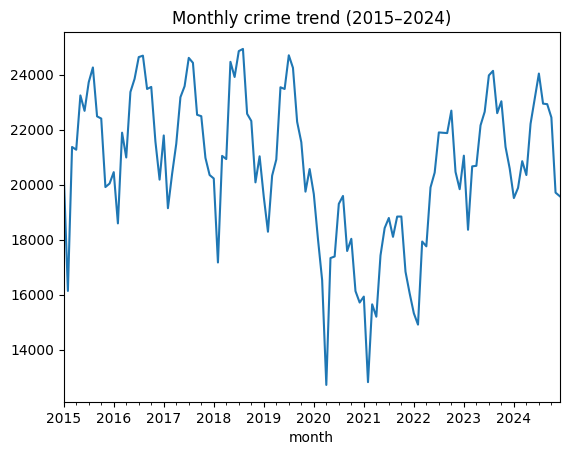

In [7]:
monthly = df.groupby("month").size()
monthly.plot(kind="line", title="Monthly crime trend (2015–2024)")

<Axes: title={'center': 'Crime by weekday'}, xlabel='weekday'>

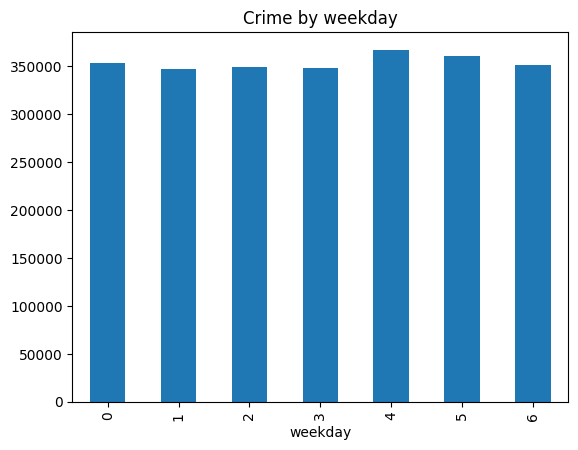

In [8]:
weekday = df.groupby("weekday").size()
weekday.plot(kind="bar", title="Crime by weekday")

<Axes: title={'center': 'Crime by hour'}, xlabel='hour'>

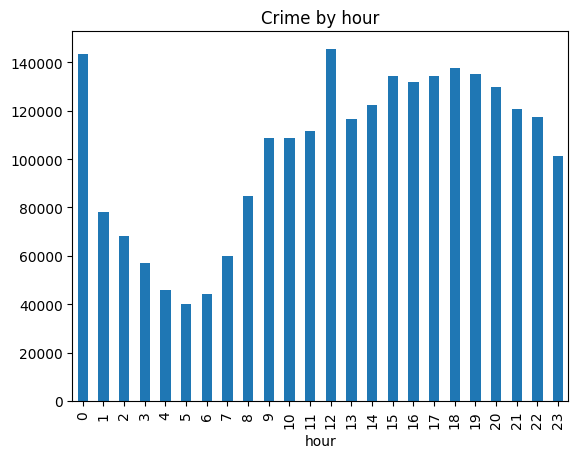

In [9]:
hourly = df.groupby("hour").size()
hourly.plot(kind="bar", title="Crime by hour")

Text(0, 0.5, 'Latitude')

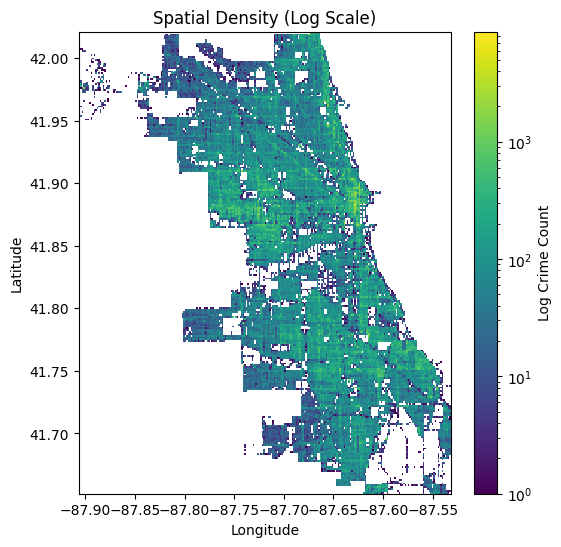

In [10]:
lat_low = df["latitude"].quantile(0.001)
lat_high = df["latitude"].quantile(0.999)

lon_low = df["longitude"].quantile(0.001)
lon_high = df["longitude"].quantile(0.999)

df_clean = df[
    (df["latitude"].between(lat_low, lat_high)) &
    (df["longitude"].between(lon_low, lon_high))
]
plt.figure(figsize=(6,6))
plt.hist2d(
    df_clean["longitude"],
    df_clean["latitude"],
    bins=250,
    norm=LogNorm()
)
plt.colorbar(label="Log Crime Count")
plt.title("Spatial Density (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

<Axes: title={'center': 'Top 10 Crime Types (2015–2024)'}, xlabel='primary_type'>

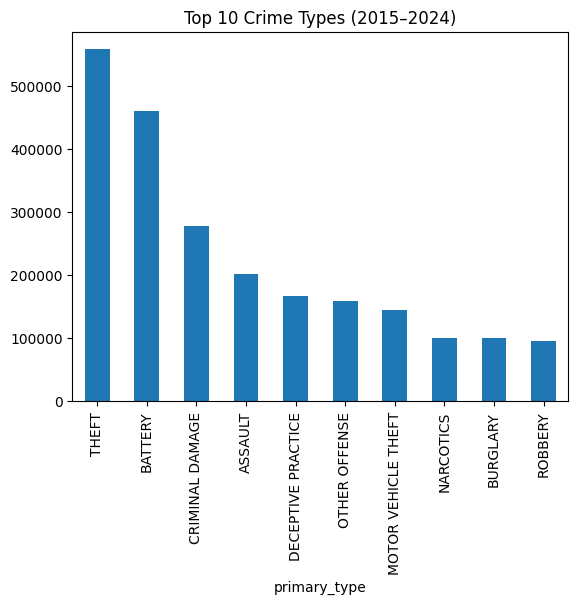

In [11]:
top_types = df["primary_type"].value_counts().head(10)
top_types.plot(kind="bar", title="Top 10 Crime Types (2015–2024)")

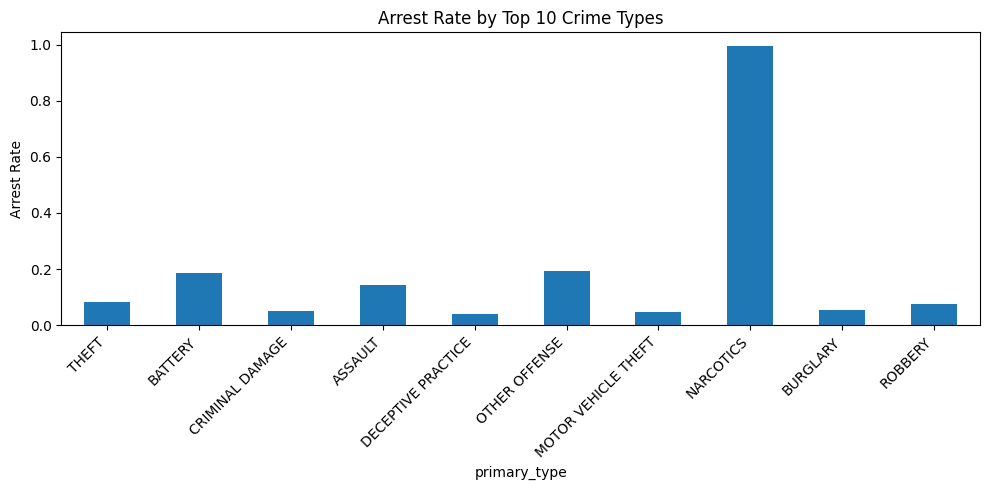

primary_type
THEFT                  0.081563
BATTERY                0.187359
CRIMINAL DAMAGE        0.048963
ASSAULT                0.144931
DECEPTIVE PRACTICE     0.039302
OTHER OFFENSE          0.191885
MOTOR VEHICLE THEFT    0.048011
NARCOTICS              0.994469
BURGLARY               0.052707
ROBBERY                0.077085
Name: arrest_bin, dtype: float64

In [17]:
df["arrest_bin"] = df["arrest"].astype(int)

arrest_rate_by_type = (
    df.groupby("primary_type")["arrest_bin"]
    .mean()
    .sort_values(ascending=False)
)

top_types = df["primary_type"].value_counts().head(10).index
arrest_rate_top = arrest_rate_by_type.loc[top_types]

plt.figure(figsize=(10, 5))
arrest_rate_top.plot(kind="bar")
plt.title("Arrest Rate by Top 10 Crime Types")
plt.ylabel("Arrest Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

arrest_rate_top

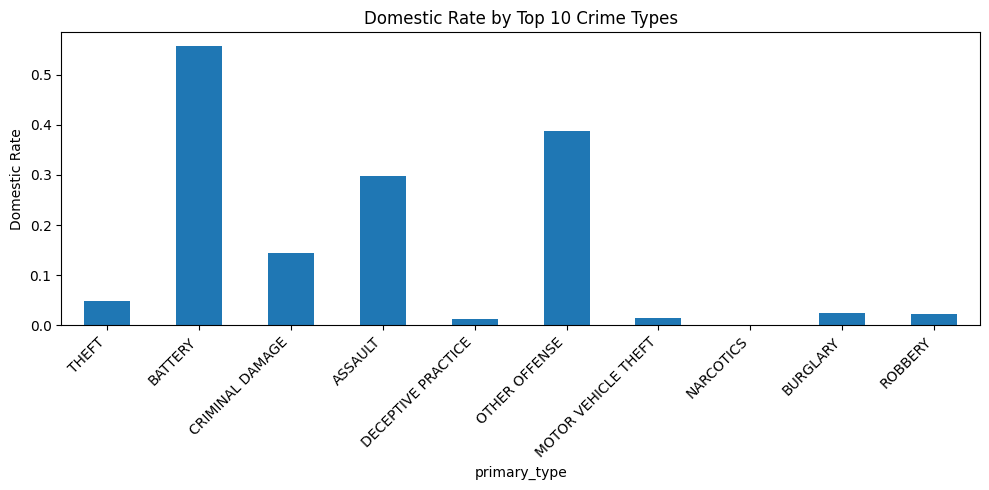

primary_type
THEFT                  0.048418
BATTERY                0.557077
CRIMINAL DAMAGE        0.143614
ASSAULT                0.298514
DECEPTIVE PRACTICE     0.012125
OTHER OFFENSE          0.388379
MOTOR VEHICLE THEFT    0.015277
NARCOTICS              0.001202
BURGLARY               0.023522
ROBBERY                0.022029
Name: domestic_bin, dtype: float64

In [18]:
# --- Crime Type vs Domestic ---
df["domestic_bin"] = df["domestic"].astype(int)

domestic_rate_by_type = (
    df.groupby("primary_type")["domestic_bin"]
    .mean()
    .sort_values(ascending=False)
)

domestic_rate_top = domestic_rate_by_type.loc[top_types]

plt.figure(figsize=(10, 5))
domestic_rate_top.plot(kind="bar")
plt.title("Domestic Rate by Top 10 Crime Types")
plt.ylabel("Domestic Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

domestic_rate_top


In [19]:
import numpy as np
import pandas as pd

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    n = confusion.sum().sum()
    if n == 0:
        return np.nan
    
    observed = confusion.values
    row_sum = observed.sum(axis=1, keepdims=True)
    col_sum = observed.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n
    
    expected = np.where(expected == 0, 1e-12, expected)
    chi2 = ((observed - expected) ** 2 / expected).sum()
    
    r, k = confusion.shape
    phi2 = chi2 / n
    return np.sqrt(phi2 / min(k-1, r-1))

v_type_arrest = cramers_v(df["primary_type"], df["arrest"])
v_type_domestic = cramers_v(df["primary_type"], df["domestic"])

print("Cramér's V (Crime Type vs Arrest):", v_type_arrest)
print("Cramér's V (Crime Type vs Domestic):", v_type_domestic)


Cramér's V (Crime Type vs Arrest): 0.5790641813899224
Cramér's V (Crime Type vs Domestic): 0.5383540085362194


In [21]:
top_districts = df["district"].value_counts().head(10).index
df_loc = df[df["district"].isin(top_districts)]

v_type_district = cramers_v(df_loc["primary_type"], df_loc["district"])

print("Cramér's V (Crime Type vs District):", v_type_district)

Cramér's V (Crime Type vs District): 0.13882678193029196
